# Introduction to Basic Portfolio Theory

Last Update: January 10th,2020

### Before You Start

This jupyter notebook is mainly designed for illustration purpose. Readers are supposed to run the code block by block from the start to the end. Skipping running any line of the code may cause error thereafter.

Readers are encourage to run the code with the existing value in the CAN BE CHANGED block before having gone through the entire notebook. Once the some block is modified, readers should run ALL its following blocks to see the changes.

## Table of Contents

[0. Set Up Environment](#0) 

[1. Preparing Data for Input and Usage](#1)
- Sanity Checking
- Addressing Missing Data
- Changing Data Frequency

[2. Evaluating Individual Stock Performance over Selected Historical Time Periods](#2)   
- Annual Returns, Volatility of Return, Sharpe Ratio, Max Drawdown
- Alpha and Beta Values

[3. Computing Covariance Matrix of Returns](#3) 
- Check for factorability

[4. Estimating Parameters of Markowitz Model](#4)

[5. Constructing Sub-model for Each Point on Efficient Frontier](#5)

[6. Drawing Full Efficient Frontier](#6)

[7. Solving for Maximum Sharpe Ratio Point](#7)
- Formulation of the Optimization Problem for Maximizing Sharpe Ratio
- Show on Efficient Frontier
- How Do Risks Change When Risk-Free Rate Is Involved?
    - Show reduce risks by combining max Sharpe point and risk free rate
    - Show increased risks by borrowing at risk free rate and levering max Sharpe point

[8. Conducting Back-Tests](#8)
- Buy-and-Hold strategy

[9. Interpreting Output Recommendations](#9)


## 0. Set Up Environment <a id="0"></a>


In [1]:
# Import the various modules

#for data manipulation
import csv
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

#for checking factorability
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity 
from factor_analyzer.factor_analyzer import calculate_kmo

from scipy.optimize import minimize #for solving optmization
from sklearn.linear_model import LinearRegression #for solving linear regression

import warnings
warnings.filterwarnings('ignore') #to suppress warning messages

## 1. Preparing Data for Input and Usage  <a id="1"></a>

### Load Stock Return Data

The dataset used in this notebook are downloaded from CRSP via [WRDS](https://wrds-www.wharton.upenn.edu/).

The first column corresponds to date information.
The second to the last column are stock returns information with the stock symbol on the first row.

- The dataset ranges from January, 2000 to June 2020;
- The return data are holding period returns (in daily frequency), adjusted for splits and dividends.

In [2]:
# Load Stock Return dataset 
file_name = 'ReturnsData_Daily.csv'
df = pd.read_csv(file_name, low_memory=False, index_col=0) # set the first column (date) as index
df.index=pd.to_datetime(df.index) # set index (i.e. date) as a datetime object
display(df)

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,-0.051966,-0.065617,-0.060338,-0.034869,-0.050505,-0.031161,-0.032457,-0.062376,-0.054291,...,0.006512,-0.029480,NaN,-0.034632,-0.008430,0.088754,NaN,-0.001606,NaN,-0.009549
2000-01-04,NaN,-0.031111,-0.033708,-0.023493,-0.059355,-0.042553,-0.001462,-0.051118,-0.062987,-0.074074,...,-0.037893,-0.017586,NaN,0.000000,-0.005313,-0.084310,NaN,-0.033780,NaN,-0.038345
2000-01-05,NaN,0.004587,-0.002907,-0.006173,0.010974,0.003704,-0.005857,-0.008418,-0.046828,-0.036500,...,0.042267,0.054516,NaN,0.017937,0.034188,0.014634,NaN,0.010544,NaN,0.001922
2000-01-06,NaN,0.047184,0.032070,0.014197,0.071913,0.065191,0.008837,0.044143,0.042789,0.019201,...,0.008295,0.049383,NaN,0.042584,0.002066,-0.086538,NaN,-0.033498,NaN,0.000956
2000-01-07,NaN,0.001453,0.022599,0.018373,-0.013924,-0.002309,-0.013139,0.017886,0.003799,0.031059,...,0.095978,-0.000735,NaN,0.017606,-0.018557,0.047368,NaN,0.013068,NaN,0.027090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,-0.026556,-0.040379,-0.044819,-0.033391,-0.039532,-0.040415,-0.015222,-0.040764,-0.033011,-0.019628,...,-0.016209,-0.047109,-0.049641,-0.041557,-0.042615,-0.017652,-0.021366,-0.020158,-0.011060,-0.025855
2020-06-25,0.024723,0.029696,0.032004,0.034862,0.038219,0.036804,0.014863,0.047856,0.045854,0.039191,...,0.009226,0.015056,0.023249,0.017914,0.015558,0.013276,0.005863,0.012636,-0.017947,0.010959
2020-06-26,-0.040303,-0.051855,-0.052300,-0.054818,-0.063511,-0.058846,-0.023433,-0.074169,-0.086480,-0.035663,...,-0.018023,-0.034315,-0.028917,-0.030826,-0.031489,-0.030726,-0.054514,-0.020016,-0.029033,-0.024227


In [3]:
# Print the total number of stocks and stock names/symbols included in the dataset
print('There are a total of', len(df.columns),'stocks included in this datafile.') 
print('The stocks included in this datafile are:')
for name in df.columns: print(name)

There are a total of 23 stocks included in this datafile.
The stocks included in this datafile are:
FRC
PNC
USB
JPM
BAC
C
RY
WFC
GS
MS
HSBC
JNJ
PFE
MRK
XOM
RDS
CVS
BP
AAPL
GOOG
MSFT
BABA
SP500


### Sanity Check

In [4]:
# Display a brief summary of the dataset 
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
FRC,2404.0,0.000734,0.017196,-0.150909,-0.007268,0.000689,0.008937,0.128799
PNC,5156.0,0.000568,0.023833,-0.413958,-0.008310,0.000269,0.009010,0.370909
USB,5156.0,0.000495,0.021910,-0.181653,-0.007648,0.000538,0.008207,0.228412
JPM,5156.0,0.000539,0.024902,-0.207274,-0.008974,0.000235,0.009709,0.250967
BAC,5156.0,0.000519,0.029287,-0.289694,-0.009532,0.000287,0.010111,0.352691
C,5156.0,0.000161,0.031202,-0.390244,-0.009944,0.000000,0.010086,0.578249
RY,5156.0,0.000625,0.015948,-0.150961,-0.006350,0.000656,0.007730,0.163435
WFC,5156.0,0.000457,0.024632,-0.238223,-0.007965,0.000155,0.008319,0.327645
GS,5156.0,0.000468,0.023717,-0.189596,-0.010136,0.000335,0.011087,0.264678
MS,5156.0,0.000511,0.031907,-0.258929,-0.011930,0.000230,0.012532,0.869835


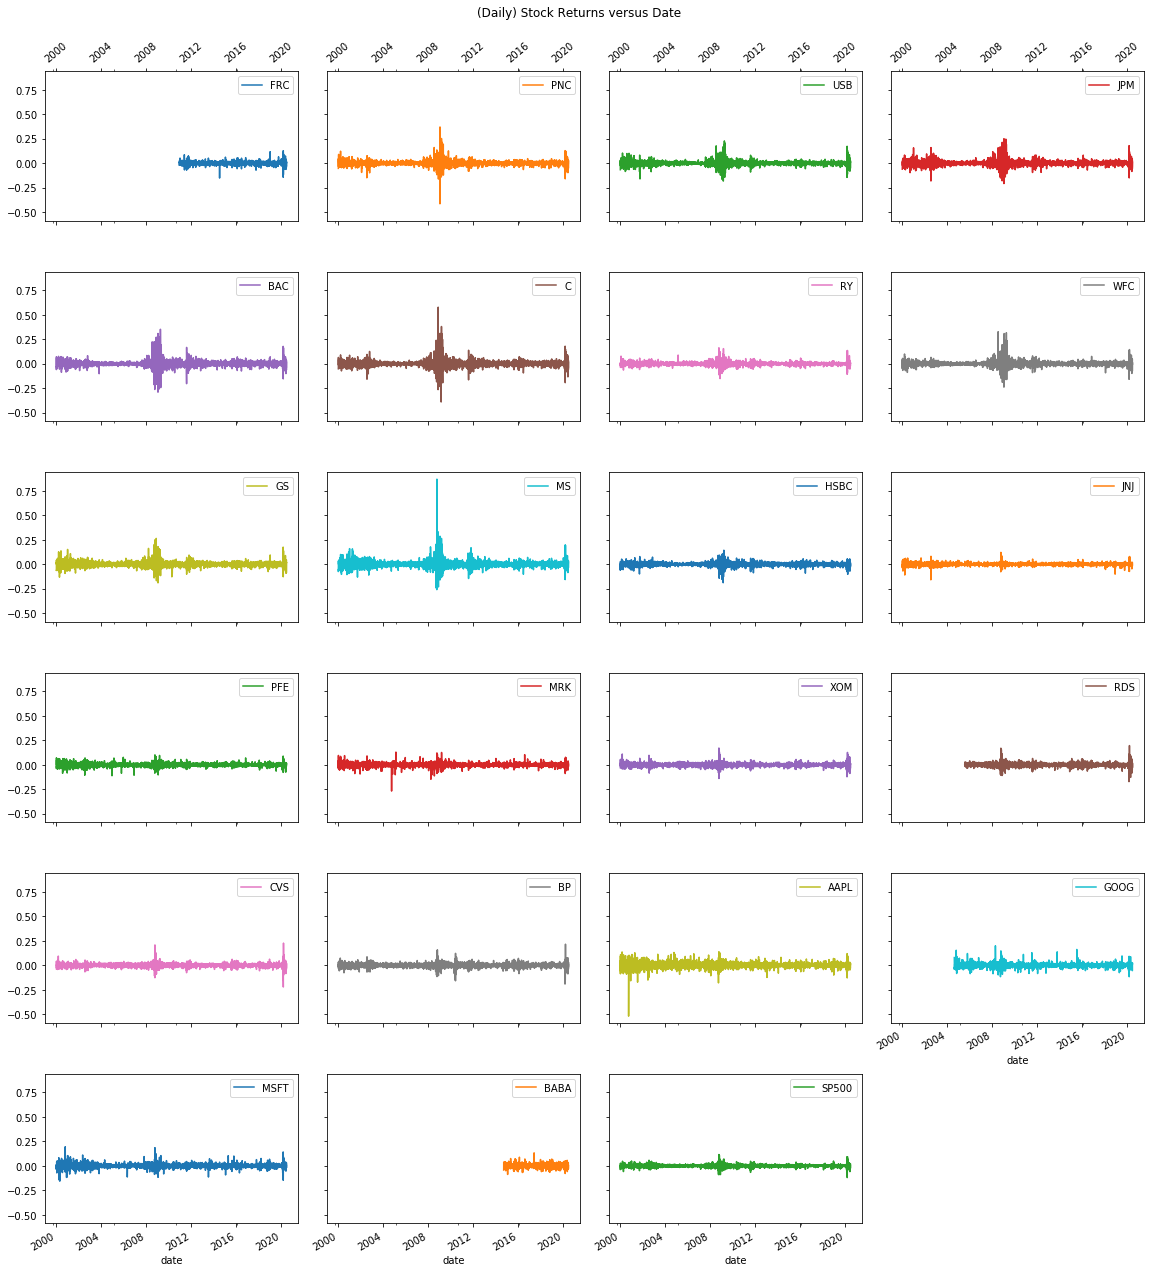

In [5]:
## Plot the Daily Stock Returns versus Date

n = len(df.columns) 
col = 4 #specify the number of columns for the plot
row = int(np.ceil(n/col)) #specify the number of rows
fig_hei = row * 3 #specify height for the plot
fig_wid = col * 4 #specify width for the lot

ax = df.plot(subplots=True, layout=(row ,col), figsize=(fig_wid, fig_hei),
             sharey=True, sharex=True, #share y and x axis for the subplots
             title = '(Daily) Stock Returns versus Date')

for i in range(col): #add x tickers to the top of the plot
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40) 
    
fig = ax[0,0].get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.93) #to indirectly adjust the location of the title

plt.show()

### Address Missing Data

Notice that there are missing data in the dataset for the given time period (January 2000 to June 2020). We want to make sure that the data we work with have the same start and end dates. 

Some options for how to deal with missing data include:
- Select the subset that includes all stocks, i.e. dropping row data such that all stocks have the same start and end dates;
- Select the subset that includes all dates, i.e. dropping column data to exclude stocks with missing data;
- Fill in the missing data from other sources or by backfilling

In this notebook, we will drop the BABA stock and then drop the row (i.e. date) data such that the rest of the stocks have the same start and end dates.

In [6]:
df = df.drop('BABA',axis = 1) #drop BABA return data from our dataframe
df = df.dropna() #drop rows which contain missing values.

display(df)

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,SP500
date,,,,,,,,,,,,,,,,,,,,,
2010-12-10,-0.018266,-0.014618,0.023607,0.015192,0.011858,0.017600,0.006356,0.006651,0.012136,0.008985,...,0.015604,0.008971,0.002500,0.011044,0.004385,0.010516,0.002510,0.001200,0.009601,0.006002
2010-12-13,-0.000365,-0.011043,-0.010208,0.001931,-0.020313,0.008386,0.002105,-0.001652,0.005995,-0.000371,...,0.009988,0.013615,0.002494,0.006462,0.015397,0.004394,0.003463,0.004069,-0.003475,0.000048
2010-12-14,-0.003285,0.006833,-0.009167,-0.017345,-0.011164,-0.024948,-0.006494,-0.013319,-0.012686,-0.011507,...,-0.004654,0.012465,-0.002488,0.008254,0.000113,0.023256,-0.004290,0.000488,0.013764,0.000911
2010-12-15,0.005126,-0.030624,-0.005397,-0.014219,-0.008871,-0.021322,-0.005383,-0.000922,-0.012670,-0.016147,...,-0.001753,0.003010,-0.004572,-0.018344,-0.004186,-0.013051,0.000218,-0.007749,0.008327,-0.005122
2010-12-16,0.007286,-0.002391,0.011628,-0.004912,0.018714,-0.000763,-0.003286,0.007721,-0.004540,-0.007252,...,0.008197,0.004910,0.005150,0.002008,0.011930,-0.002508,0.002778,0.002389,0.004937,0.006185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,-0.026556,-0.040379,-0.044819,-0.033391,-0.039532,-0.040415,-0.015222,-0.040764,-0.033011,-0.019628,...,-0.017699,-0.016209,-0.047109,-0.049641,-0.041557,-0.042615,-0.017652,-0.021366,-0.020158,-0.025855
2020-06-25,0.024723,0.029696,0.032004,0.034862,0.038219,0.036804,0.014863,0.047856,0.045854,0.039191,...,0.004039,0.009226,0.015056,0.023249,0.017914,0.015558,0.013276,0.005863,0.012636,0.010959
2020-06-26,-0.040303,-0.051855,-0.052300,-0.054818,-0.063511,-0.058846,-0.023433,-0.074169,-0.086480,-0.035663,...,-0.008663,-0.018023,-0.034315,-0.028917,-0.030826,-0.031489,-0.030726,-0.054514,-0.020016,-0.024227


In [7]:
print('Any missing values in the dataframe now?')
print(df.isnull().values.any())

Any missing values in the dataframe now?
False


### Changing Data Frequency

We can convert our daily return to returns in a different frequency via the *resample* function. 

In this notebook, we will be using weekly return data, so we will need to convert our daily returns to weekly returns. To do so, one can simply multiply the total returns (i.e. daily returns plus 1) within a week and then subtract the resulting product by 1.

Note that in our example dataset (see the dataframe above), the week of 2010-12-12 has only one date of the returns while the week of 2020-07-05 have only two dates of the returns, so we would like to remove the weekly returns data for that two weeks to account for the "missing" data.

In [8]:
# Convert daily return data to weekly return
df_week = (df+1).resample('W').prod() - 1
df_week = df_week.drop(df_week.index[[0]]) #mannually remove the returns data for the first week
df_week = df_week.drop(df_week.index[[-1]]) #mannually remove the returns data for the last week
display(df_week)

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,SP500
date,,,,,,,,,,,,,,,,,,,,,
2010-12-19,0.023713,-0.035768,-0.009452,-0.042481,-0.017969,-0.014676,-0.025839,-0.010241,-0.026297,-0.026345,...,5.874812e-04,0.024285,-0.000138,-0.010153,0.016776,0.000231,0.000156,-0.002381,0.020574,0.002830
2010-12-26,0.037063,0.027521,0.031297,0.060752,0.038983,-0.004256,0.010413,0.034380,0.021703,0.044588,...,3.405802e-02,-0.005208,0.014271,0.020826,0.024748,0.017341,0.009327,0.022733,0.014246,0.010339
2011-01-02,0.000687,0.010149,-0.000004,0.008080,0.021440,0.010684,0.018083,0.000001,0.003342,-0.007296,...,-5.676861e-03,-0.006889,-0.001093,0.016748,0.006285,0.003864,-0.003215,-0.016981,-0.013780,0.000692
2011-01-09,0.048763,0.020092,-0.032628,0.029924,0.068216,0.044398,0.000573,0.016457,0.015045,0.036384,...,4.740118e-02,0.036347,0.033781,-0.015423,-0.000658,0.043242,0.042038,0.037830,0.024722,0.011020
2011-01-16,0.026523,0.038476,0.049062,0.029103,0.070175,0.038461,0.038366,0.039682,0.025251,0.027659,...,-7.686505e-07,-0.083533,0.029767,0.036045,0.017984,0.068794,0.036771,0.012555,-0.010489,0.017099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,0.111717,0.090144,0.079866,0.087626,0.064430,0.086395,0.101580,0.095159,0.098984,0.101420,...,1.839991e-02,0.056960,0.019506,-0.008995,0.015730,0.006964,-0.002980,0.014351,-0.001417,0.030066
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,-5.760602e-02,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555,0.049147
2020-06-14,-0.111648,-0.134890,-0.114703,-0.102130,-0.118463,-0.112299,-0.064237,-0.116829,-0.074064,-0.065617,...,-6.223929e-02,-0.065038,-0.111341,-0.087901,-0.083523,-0.106819,0.022022,-0.018820,0.002886,-0.047783


### Extract S\&P500 data

Note that S\&P 500 is included in our dataset, but we will not be using this market index to construct portfolio in this notebook. Therefore, we would like to separate it from the above dataframe. 

In [9]:
# Store weekly return of SP500 
SP500 = df_week[['SP500']]
display(SP500)

,SP500
date,
2010-12-19,0.002830
2010-12-26,0.010339
2011-01-02,0.000692
2011-01-09,0.011020
2011-01-16,0.017099
...,...
2020-05-31,0.030066
2020-06-07,0.049147
2020-06-14,-0.047783


In [10]:
# Exclude S&P500 return data from our stock return dataframe (and rename)
data = df_week.drop('SP500',axis = 1) 

### Load T-bill Data

We will use T-Bill returns as the risk-free rate, which is required in the calculation of the Sharpe ratio.

Data Source for weekly T-Bill return: https://fred.stlouisfed.org/series/WTB3MS#0

Note that the data downloaded from FRED has unit in percentage, and it is percent per annum. Moreover, although it is weekly data, it ends on every Friday, yet the weekly return data above is ending on Sunday. So we need to edit its format.

In [11]:
## Read and Edit data into the right format
file_name = 'WTB3MS.csv' #datafile downloaded from FRED
df = pd.read_csv(file_name)

df['DATE']=pd.to_datetime(df['DATE']) #set the DATE column as datetime object
df['WTB3MS'] = pd.to_numeric(df['WTB3MS'], errors='coerce') #set the return column as numeric

RET_data=pd.DataFrame(columns=['RET'], index=df.DATE) #create a new dataframe 
RET_data['RET'] = (df['WTB3MS'].values/100 + 1) ** (1/52) - 1 #edit the unit of the return data

RET_data_weekly = (RET_data['RET']+1).resample('W').prod() - 1 #convert the data to the same weekly frequency as above
TBill = pd.DataFrame(columns=['T-Bill'], index=RET_data_weekly.index)
TBill['T-Bill'] = RET_data_weekly

ind = (TBill.index >= df_week.index[[0]][0])*(TBill.index <= df_week.index[[-1]][0])
TBill = TBill[ind] #keep the same start and end date as the stock returns data
display(TBill)

,T-Bill
DATE,
2010-12-19,0.000027
2010-12-26,0.000027
2011-01-02,0.000027
2011-01-09,0.000027
2011-01-16,0.000029
...,...
2020-05-31,0.000029
2020-06-07,0.000029
2020-06-14,0.000033


### Specify a given time period 

We will work with the specified time period for the rest of the notebook. 

CAUTION: If you change the specified time period in next cell:
- AND you have NOT run the rest of the codes in section 1 yet, simply continue;
- BUT you HAVE RUN the rest of the codes in section 1, please re-run the ENTIRE section 1 before proceeding to the next section.

In [12]:
###########################################   CAN BE CHANGED  #############################################

start_date = '2010-12-19'
end_date   = '2020-06-28'

###########################################   CAN BE CHANGED  #############################################

In [13]:
# Extract data for the given time period
ind = (data.index >= start_date)*(data.index <= end_date)

data = data[ind]
display(data)

SP500 = SP500[ind]
display(SP500)

TBill = TBill[ind]
display(TBill)

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,JNJ,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT
date,,,,,,,,,,,,,,,,,,,,,
2010-12-19,0.023713,-0.035768,-0.009452,-0.042481,-0.017969,-0.014676,-0.025839,-0.010241,-0.026297,-0.026345,...,0.010177,5.874812e-04,0.024285,-0.000138,-0.010153,0.016776,0.000231,0.000156,-0.002381,0.020574
2010-12-26,0.037063,0.027521,0.031297,0.060752,0.038983,-0.004256,0.010413,0.034380,0.021703,0.044588,...,-0.004636,3.405802e-02,-0.005208,0.014271,0.020826,0.024748,0.017341,0.009327,0.022733,0.014246
2011-01-02,0.000687,0.010149,-0.000004,0.008080,0.021440,0.010684,0.018083,0.000001,0.003342,-0.007296,...,-0.006426,-5.676861e-03,-0.006889,-0.001093,0.016748,0.006285,0.003864,-0.003215,-0.016981,-0.013780
2011-01-09,0.048763,0.020092,-0.032628,0.029924,0.068216,0.044398,0.000573,0.016457,0.015045,0.036384,...,0.012127,4.740118e-02,0.036347,0.033781,-0.015423,-0.000658,0.043242,0.042038,0.037830,0.024722
2011-01-16,0.026523,0.038476,0.049062,0.029103,0.070175,0.038461,0.038366,0.039682,0.025251,0.027659,...,-0.000798,-7.686505e-07,-0.083533,0.029767,0.036045,0.017984,0.068794,0.036771,0.012555,-0.010489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,0.111717,0.090144,0.079866,0.087626,0.064430,0.086395,0.101580,0.095159,0.098984,0.101420,...,0.030339,1.839991e-02,0.056960,0.019506,-0.008995,0.015730,0.006964,-0.002980,0.014351,-0.001417
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,-0.009747,-5.760602e-02,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555
2020-06-14,-0.111648,-0.134890,-0.114703,-0.102130,-0.118463,-0.112299,-0.064237,-0.116829,-0.074064,-0.065617,...,-0.034964,-6.223929e-02,-0.065038,-0.111341,-0.087901,-0.083523,-0.106819,0.022022,-0.018820,0.002886


,SP500
date,
2010-12-19,0.002830
2010-12-26,0.010339
2011-01-02,0.000692
2011-01-09,0.011020
2011-01-16,0.017099
...,...
2020-05-31,0.030066
2020-06-07,0.049147
2020-06-14,-0.047783


,T-Bill
DATE,
2010-12-19,0.000027
2010-12-26,0.000027
2011-01-02,0.000027
2011-01-09,0.000027
2011-01-16,0.000029
...,...
2020-05-31,0.000029
2020-06-07,0.000029
2020-06-14,0.000033


## 2. Evaluating Individual Stock Performance over Selected Historical Time Periods <a id="2"></a>

### Find the Annual Returns, Volatility of Return, Sharpe Ratio, Max Drawdown

In [14]:
Freq = 52 # frequency factor (given weekly data, it is 52)

# Functions for annualizing returns and standard deviation
def ann_ret(x):
    return (x+1)**Freq-1
def ann_std(x):
    return x*np.sqrt(Freq)

# Function used to find the Annualized geometric mean of x [note: x is weekly data]
def ann_geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * Freq / n) - 1

# Function used to find the Annualized Sharpe Ratio of x
def ann_sr(x, rf):    
    n = len(x)
    ret_expected = np.sum(x-rf)/n
    ret_avg = np.sum(x)/n
    std_dev = np.sqrt( np.sum( (x - ret_avg)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**Freq-1
    annu_std_dev = std_dev * np.sqrt(Freq)
    return annu_ret_expected/annu_std_dev

# Function used to find the Maximum drawdown
def mdd(x):
    wealth = (x+1).cumprod() #x is a return vector
    cummax = wealth.cummax() #determine cumulative maximum value
    drawdown = wealth/cummax - 1 #calculate drawdown vector
    return drawdown.min()

In [15]:
# Output summary statistics information:
# Calculate and show the Mean, Geometric Mean, and Standard Deviation, Sharpe Ratio, Maximum Drawdown (with 2 decimals)
n_dec = 2
SumStat = pd.DataFrame(index = data.columns)
SumStat['Geo Mean(Annu,%)'] = np.round( data.apply(ann_geo_mean)*100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round( ann_std(data.std())*100 , n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round( data.apply(ann_sr, rf=TBill['T-Bill']) , n_dec)
SumStat['Max Drawdown(%)'] = np.round(data.apply(mdd)*100, n_dec)
display(SumStat)

,"Geo Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
FRC,15.80,25.96,0.73,-33.06
PNC,8.10,26.09,0.43,-46.63
USB,5.80,24.09,0.34,-48.13
JPM,11.67,26.71,0.56,-39.64
BAC,7.69,33.47,0.39,-66.00
C,1.44,34.43,0.20,-53.90
RY,6.68,19.96,0.41,-35.26
WFC,1.12,26.95,0.16,-60.90
GS,2.72,29.02,0.22,-48.89
MS,7.82,33.69,0.40,-58.41


### Find the Alpha and Beta Values

In [16]:
# Function for performing linear regression and returning coefficient as well as intercept
def LR(X,y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))  # perform linear regression
    return reg.coef_,reg.intercept_

In [17]:
# Calculate and display alpha and beta for each stock

n_dec = 3 # rounding to this decimal places

# Get excess returns of the stocks and the market
ex_ret = data.sub(TBill['T-Bill'], axis=0)
mkt_ex_ret = SP500.sub(TBill['T-Bill'], axis=0)

# Calculate the alpha and beta for each stock
n = len(ex_ret.columns)
beta = np.zeros(n)
alpha = np.zeros(n)
for i in range(n):
    beta[i],alpha[i] = LR(mkt_ex_ret.values,ex_ret[ex_ret.columns[i]].values)
    
# Display the alpha and beta information
AlphaBeta = pd.DataFrame(index = data.columns)
AlphaBeta['Alpha(Annu,%)']  = np.round( ann_ret(alpha)*100, n_dec)
AlphaBeta['Beta']   = np.round(beta , n_dec)
display(AlphaBeta)

,"Alpha(Annu,%)",Beta
FRC,7.489,1.025
PNC,-1.788,1.245
USB,-3.559,1.159
JPM,1.262,1.280
BAC,-2.551,1.501
C,-9.963,1.730
RY,-1.336,0.924
WFC,-7.866,1.235
GS,-7.370,1.397
MS,-3.301,1.602


## 3. Computing Covariance Matrix of Returns <a id="3"></a>

In [18]:
# Calculate and output the covariance matrix for the stock returns
data_cov_mat = data.cov()
data_cov_mat_annu = data_cov_mat * Freq # Annualize the co-variance matrix
print("The Annualized Covariance matrix (for the weekly returns) is: ")
display(data_cov_mat_annu)

The Annualized Covariance matrix (for the weekly returns) is: 


,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,JNJ,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT
FRC,0.067394,0.048483,0.041604,0.044259,0.056190,0.056529,0.025321,0.043375,0.047998,0.052201,...,0.016048,0.018337,0.015403,0.026568,0.025501,0.030534,0.028785,0.024591,0.024426,0.020148
PNC,0.048483,0.068073,0.054789,0.057737,0.070704,0.072872,0.031488,0.058332,0.058108,0.066115,...,0.016859,0.018880,0.017163,0.034044,0.031634,0.036236,0.035160,0.027142,0.029431,0.026041
USB,0.041604,0.054789,0.058019,0.052261,0.062535,0.066834,0.030775,0.056775,0.051910,0.057925,...,0.015190,0.017428,0.016092,0.034508,0.034279,0.034912,0.037040,0.026079,0.028350,0.023695
JPM,0.044259,0.057737,0.052261,0.071323,0.077028,0.080352,0.036494,0.058268,0.066143,0.075419,...,0.018416,0.021772,0.020279,0.036391,0.036036,0.039826,0.039332,0.026889,0.029785,0.026996
BAC,0.056190,0.070704,0.062535,0.077028,0.112034,0.100327,0.040154,0.070144,0.079817,0.092802,...,0.019271,0.023409,0.020823,0.039844,0.038170,0.043126,0.043702,0.035045,0.035470,0.032068
C,0.056529,0.072872,0.066834,0.080352,0.100327,0.118556,0.047438,0.073440,0.083850,0.096354,...,0.023472,0.025944,0.023583,0.047695,0.049569,0.052551,0.055695,0.040685,0.041170,0.036210
RY,0.025321,0.031488,0.030775,0.036494,0.040154,0.047438,0.039836,0.033824,0.037890,0.043829,...,0.014066,0.016921,0.014051,0.028034,0.034236,0.032854,0.035539,0.022394,0.020764,0.018586
WFC,0.043375,0.058332,0.056775,0.058268,0.070144,0.073440,0.033824,0.072635,0.058434,0.065217,...,0.015980,0.020202,0.018656,0.037094,0.037283,0.036993,0.039870,0.025704,0.029264,0.023911
GS,0.047998,0.058108,0.051910,0.066143,0.079817,0.083850,0.037890,0.058434,0.084221,0.084882,...,0.019434,0.021991,0.019246,0.038091,0.037906,0.042005,0.042436,0.031803,0.030605,0.028498
MS,0.052201,0.066115,0.057925,0.075419,0.092802,0.096354,0.043829,0.065217,0.084882,0.113531,...,0.021808,0.026725,0.022088,0.044100,0.045940,0.048876,0.049878,0.033037,0.036736,0.034966


### Check for factorability

A matrix that is **factorable** should include several sizable correlations.If none of the correlations is significantly different from zero, then a parsimonious explanation CANNOT be found of the covariance structure and hence no factor analysis can be done.Thus if there are no correlations significantly different from zero, no interesting studies such as factor analysis etc. can be done on the variables.

There are two methods to check the factorability of the dataset:
- Bartlett’s Test
    - Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix;
    - If the test found statistically insignificant, you should NOT employ a factor analysis.
- Kaiser-Meyer-Olkin (KMO) Test
    - KMO Test measures the suitability of data for factor analysis and determines the adequacy for each observed variable as well as for the complete model;
    - It estimates the proportion of variance among all the observed variable. Lower proportion is more suitable for factor analysis;
    - KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

Reference: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [19]:
chi_square_value,p_value = calculate_bartlett_sphericity(data)
print("In this Bartlett ’s test, the p-value is:", p_value)
if (p_value < 0.05):
    print("The test was statistically significant; the observed correlation matrix is not an identity matrix.")

In this Bartlett ’s test, the p-value is: 0.0
The test was statistically significant; the observed correlation matrix is not an identity matrix.


In [20]:
kmo_all,kmo_model = calculate_kmo(data)
print("In this KOM test, the overall KMO is:", kmo_model)
if (kmo_model > 0.6):
    print("Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.")

In this KOM test, the overall KMO is: 0.9584761419599392
Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.


## 4. Estimating parameters of Markowitz Model <a id="4"></a>

### Set Time Horizon for Performing Portfolio Optimization

We will use the historical performance of the specified time horizon to perform portfolio optimization and calculate the weights of stocks.

CAUTION: the start and end date should be in the range of what we specified previously in Section 1.

In [21]:
###########################################   CAN BE CHANGED  #############################################

start_date_train = '2010-12-19'
end_date_train   = '2020-06-28'

###########################################   CAN BE CHANGED  #############################################

In [22]:
# Extract stock return, S&P500, and T-Bill data for the given time period
ind = (data.index >= start_date_train)*(data.index <= end_date_train)
data_train = data[ind].copy()
SP500_train = SP500[ind].copy()
TBill_train = TBill[ind].copy()

### Formulation of Markowitz Problem

- Minimize the portfolio variance given:
    - the budget constraint, 
    - non-negativity contraint (all weight must be positive, i.e. no shorting),
    - return constraint (the expected return of the portfolio should be greater than or equal to a given number r-bar).

Objective:  $$ \text{min } w^T Q w$$

Constriants:

1) budget constraint: $$ \textbf{1}^T w = 1 $$
2) nonnegative constraint: $$w \geq 0$$
3) return constraint: $$\mu^T w \geq \bar{r}$$

where:
- $w$ = vector for weights (amount of investment)
- $Q$ = covariance matrix
- $\textbf{1}$ = vector of 1's
- $\mu$ is the vector for expected return 
- $\bar{r}$ is the target return

Notice that all we need from the data is the expected return and covariance matrix for solving the Markowitz Problem. We will assume the expected return follows the historical mean and the covariance matrix resembles the historical covariance. 

In [23]:
# Get the mean and covariance matrix of the training data
data_train_mean = data_train.mean()
data_train_cov_mat = data_train.cov()

# Function to compute the expected return for the portfolio
def EReturn(w):
    EReturn = w @ data_train_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol(w):
    pvar = w @ data_train_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem 
# with specified target return r
def MarkPortOpt(r, silent = False):

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w # nonnegative constraint
    def constraint4(w):
        diff = EReturn(w) - r
        return diff # return constraint    
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(data_train.columns))

    # Solve the problem
    sol = minimize(PVol, w0, method='SLSQP',constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exit successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [24]:
# Find the solution given a specified target return r 
sol = MarkPortOpt(r = 0.001, silent = False)

Solution to the Markowitz Problem with r =   0.1 %:
     fun: 0.019097228819160747
     jac: array([0.01970189, 0.02261347, 0.02082111, 0.02487559, 0.02815297,
       0.03217214, 0.01912878, 0.02275553, 0.02585141, 0.02985946,
       0.019195  , 0.01909916, 0.01903301, 0.0191413 , 0.02047485,
       0.02148851, 0.02331676, 0.0226679 , 0.01893082, 0.01885147,
       0.01901952])
 message: 'Optimization terminated successfully.'
    nfev: 530
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([-8.39196495e-17, -1.16480862e-17,  8.85593591e-18, -7.22502981e-18,
       -2.37995570e-17, -9.90422764e-18,  7.43542741e-02,  9.70984410e-18,
       -6.78647413e-18, -1.14397756e-17,  1.51223159e-01,  4.23800993e-01,
        8.56659389e-02,  1.31553807e-01,  5.56948120e-18, -7.40028499e-18,
        1.53449059e-18,  2.29483768e-18,  4.33328776e-02,  2.70813213e-02,
        6.29876298e-02])



## 5. Constructing Sub-Model for Each Point on Efficient Frontier <a id="5"></a>

We will iterate the above *MarkPortOpt* function to get a set of points on efficient frontier.

In [25]:
###########################################   CAN BE CHANGED  #############################################

# Number of targeted returns (or r-bar) we want to set
numR = 14

# Setting target return r-bar
r_bar = np.array([i for i in range(numR-3)])*0.0003 + 0.002 #using same increment for the first several r-bars
r_bar = np.append(r_bar,np.array([0.00505,0.0051,0.00515])) #using different increments for the last several r-bars

###########################################   CAN BE CHANGED  #############################################

In [26]:
# Print the number of target returns actually specified:
if (len(r_bar) != numR):
    numR = len(r_bar)
print("Number of targeted returns (or r-bar) specified is: ", numR)

Number of targeted returns (or r-bar) specified is:  14


In [27]:
# Two lists to record the volatility and expected return for each portfilio 
port_vol = []
port_return = []

# A matrix storing the portfolio alloaction
alloc_r = np.zeros((len(data_train.columns),numR))

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt(r, silent = True)
    
    if (not sol['success']): #check if the optimizer exit successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        alloc_r[:,i] = sol['x']
        port_vol.append(sol['fun'])
        port_return.append(EReturn(sol['x']))
    print("")
    
port_vol = np.asarray(port_vol)
port_return = np.asarray(port_return)

num_rbar = len(port_vol) #update the number of r-bar recorded/kept
print("The number of recoreded the efficient frontier points is:", num_rbar)

* For the case r-bar =  0.2 %:
Optimization terminated successfully.

* For the case r-bar =  0.23 %:
Optimization terminated successfully.

* For the case r-bar =  0.26 %:
Optimization terminated successfully.

* For the case r-bar =  0.29 %:
Optimization terminated successfully.

* For the case r-bar =  0.32 %:
Optimization terminated successfully.

* For the case r-bar =  0.35 %:
Optimization terminated successfully.

* For the case r-bar =  0.38 %:
Optimization terminated successfully.

* For the case r-bar =  0.41 %:
Optimization terminated successfully.

* For the case r-bar =  0.44 %:
Optimization terminated successfully.

* For the case r-bar =  0.47 %:
Optimization terminated successfully.

* For the case r-bar =  0.5 %:
Optimization terminated successfully.

* For the case r-bar =  0.505 %:
Optimization terminated successfully.

* For the case r-bar =  0.51 %:
Optimization terminated successfully.

* For the case r-bar =  0.515 %:
NOTE: solution to this r-bar will be dropped!

In [28]:
# Display the optimal allocation for each specified target return
DF_Alloc_R = pd.DataFrame(alloc_r)
DF_Alloc_R.index = data_train.columns
DF_Alloc_R.columns = [str(round(ann_ret(r)*100, 1))+"%" for r in r_bar]
DF_Alloc_R = DF_Alloc_R.loc[:,(DF_Alloc_R!=0).any(axis=0)] #drop the r-bar solution(s) that failed the opt. problem

print('Optimal allocation (in %) for specified (annualized) target return:')
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Optimal allocation (in %) for specified (annualized) target return:


,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,29.9%,30.3%
FRC,-0.0,-0.0,0.8,2.8,5.4,6.8,8.0,6.9,6.5,6.6,0.0,-0.0,0.0
PNC,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
USB,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
JPM,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
BAC,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
C,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
RY,7.4,7.5,6.9,6.4,4.2,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
WFC,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
GS,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
MS,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


## 6. Drawing Full Efficient Frontier <a id="6"></a>

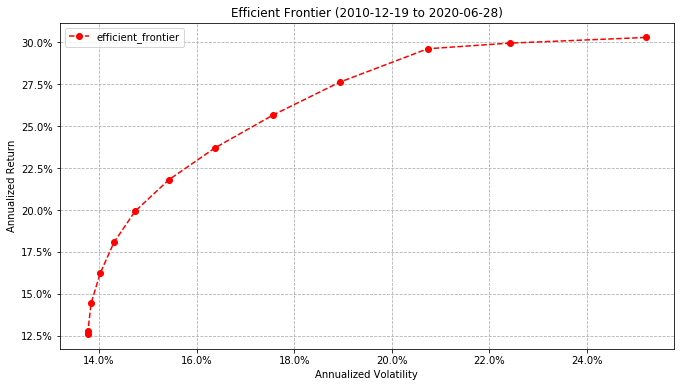

In [29]:
# Plotting efficient frontier
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='efficient_frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## 7. Solving for Maximum Sharpe Ratio Point <a id="7"></a>

### Formulation of the Optimization Problem for Maximizing Sharpe Ratio:

Objective:  $$ \text{max }_{w \in \mathbb{R}^n} \frac{\mu^T w - r_{f}}{ \sqrt{w^T Q w}}$$

Constriants:

1) budget constraint: $$ \textbf{1}^T w = 1 $$
2) nonnegative constraint: $$w \geq 0$$

where:
- $w$ = vector for weights (amount of investment)
- $\mu$ is the vector for expected return 
- $r_{f}$ is the risk-free rate
- $Q$ = covariance matrix
- $\textbf{1}$ = vector of 1's

In [30]:
# Function to compute the annualized sharpe ratio for the portfolio given portfolio weight
# Note that it returns the -1 * Annualized Sharpe Ratio 
def AnnSR(w, data = data_train, rf = TBill_train['T-Bill'].mean()):
    excess_ret = data @ w - rf 
    AnnSR = ann_ret(excess_ret.mean())/ann_std(PVol(w))
    return AnnSR


# Function to find the optimal portfolio that maximize the Sharpe ratio 
# Returns the optimal solution
def MaxSR(data = data_train, rf = TBill_train['T-Bill'].mean(), silent = False):
    
    #Objective Function
    def SR(w):
        excess_ret = data @ w - rf 
        SR = (excess_ret.mean())/(PVol(w))
        return -SR
    
    n = len(data.columns)
    
    #Bounds
    bnds = tuple((0,1) for i in range(n)) # nonnegativity constraint

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    cons = {'type': 'eq', 'fun': constraint1}
    
    # Initial x0
    w0 = np.array(np.ones(n))
    
    # Solve the problem
    sol = minimize(SR, w0, method='SLSQP', bounds=bnds, constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Max Sharpe Ratio Problem is:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exist successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [31]:
# Find the optimal portfolio that maximize Sharpe Ratio
sol = MaxSR()
w_SR = sol['x'] #the portfolio weight with highest Sharpe Ratio

# Calculate the volatility and expected return for the optimal portfolio
opt_vol = PVol(sol['x'])
opt_return = EReturn(sol['x'])
sr = AnnSR(sol['x'])

# Print (annualized) return, volatiltiy and Sharpe ratio information
print("* The expected return (annualized) for the optimal portfolio is ", ann_ret(opt_return) )
print("* The volatility (annualized) for the optimal portfolio is ", ann_std(opt_vol) )
print("* The Sharpe ratio (annualized) for the optimal portfolio is ", sr)
print()

# Display the optimal allocation after adding in the allocation correspond to the max SR
DF_Alloc_R['maxSR'] = w_SR 
print('Optimal allocation (in %) for specified target return:')
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Solution to the Max Sharpe Ratio Problem is:
     fun: -0.17600181610148688
     jac: array([-0.00553775,  0.06357689,  0.07243118,  0.03947621,  0.08448879,
        0.15450635,  0.04481182,  0.1058996 ,  0.11510324,  0.08872716,
        0.11135987, -0.00479001,  0.00050889, -0.00432974,  0.1168577 ,
        0.11333274,  0.09423184,  0.11794931, -0.0052194 ,  0.00565027,
       -0.00479412])
 message: 'Optimization terminated successfully.'
    nfev: 184
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([6.81694208e-02, 0.00000000e+00, 1.74122869e-16, 0.00000000e+00,
       2.42861287e-17, 1.98463208e-16, 0.00000000e+00, 9.99634403e-17,
       1.79977561e-17, 3.44776291e-17, 4.61870125e-17, 1.31326366e-01,
       0.00000000e+00, 9.07028933e-02, 0.00000000e+00, 8.70072243e-17,
       4.13623129e-17, 0.00000000e+00, 2.47625259e-01, 0.00000000e+00,
       4.62176061e-01])

* The expected return (annualized) for the optimal portfolio is  0.25067746023504456
* The volatilit

,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,29.9%,30.3%,maxSR
FRC,-0.0,-0.0,0.8,2.8,5.4,6.8,8.0,6.9,6.5,6.6,0.0,-0.0,0.0,6.8
PNC,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0
USB,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0
JPM,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
BAC,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
C,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
RY,7.4,7.5,6.9,6.4,4.2,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
WFC,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
GS,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
MS,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0


### Show on Efficient Frontier

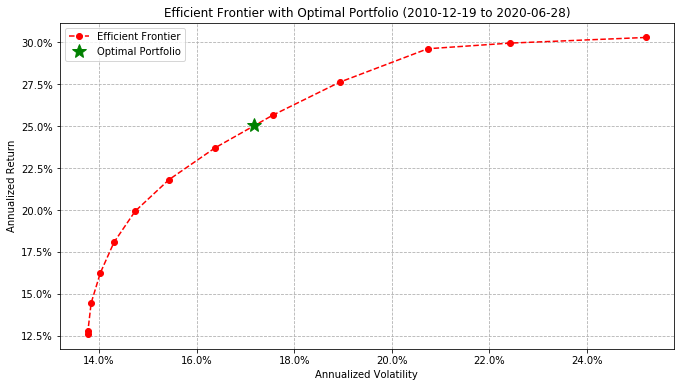

In [32]:
# Plotting efficient frontier and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### How Do Risks Change When Risk-Free Rate Is Involved?

We will include risk-free rate as one of the assets in our portfolio, then re-do the calculations (with slight modifications) to see how that will affect the efficient frontier.

Note that for this new efficient frontier, which the risk-free rate is involved, we will only assume nonnegative constraints on the stock returns; that is, the weight on the risk-free rate does NOT have to be nonnegative, which means that it is possible to short risk-free rate and lever our portfolio.

In [33]:
# Join the stock returns dataframe with T-Bill return dataframe
data_train_with_rf = data_train.copy()
data_train_with_rf = data_train_with_rf.join(TBill_train)

In [34]:
# Get the mean and covariance matrix of the training data
data_train_with_rf_mean = data_train_with_rf.mean()
data_train_with_rf_cov_mat = data_train_with_rf.cov()

# Function to compute the expected return for the portfolio
def EReturn_with_rf(w):
    EReturn = w @ data_train_with_rf_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol_with_rf(w):
    pvar = w @ data_train_with_rf_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem 
# with specified target return r
def MarkPortOpt_with_rf(r, silent = False):

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w[:-1] # nonnegative constraint placed on stock returns only
    def constraint4(w):
        diff = EReturn_with_rf(w) - r
        return diff # return constraint    
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(data_train_with_rf.columns))

    # Solve the problem
    sol = minimize(PVol_with_rf, w0, method='SLSQP',constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exist successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [35]:
# Two lists to record the volatility and expected return for each portfilio 
port_vol_with_rf = []
port_return_with_rf = []

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt_with_rf(r, silent = True)
    
    if (not sol['success']): #check if the optimizer exist successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        port_vol_with_rf.append(sol['fun'])
        port_return_with_rf.append(EReturn_with_rf(sol['x']))
    print("")
    
port_vol_with_rf = np.asarray(port_vol_with_rf)
port_return_with_rf = np.asarray(port_return_with_rf)

num_rbar = len(port_vol_with_rf) #update the number of r-bar recorded/kept
print("The number of recoreded the efficient frontier points is:", num_rbar)

* For the case r-bar =  0.2 %:
Optimization terminated successfully.

* For the case r-bar =  0.23 %:
Optimization terminated successfully.

* For the case r-bar =  0.26 %:
Optimization terminated successfully.

* For the case r-bar =  0.29 %:
Optimization terminated successfully.

* For the case r-bar =  0.32 %:
Optimization terminated successfully.

* For the case r-bar =  0.35 %:
Optimization terminated successfully.

* For the case r-bar =  0.38 %:
Optimization terminated successfully.

* For the case r-bar =  0.41 %:
Optimization terminated successfully.

* For the case r-bar =  0.44 %:
Optimization terminated successfully.

* For the case r-bar =  0.47 %:
Optimization terminated successfully.

* For the case r-bar =  0.5 %:
Optimization terminated successfully.

* For the case r-bar =  0.505 %:
Optimization terminated successfully.

* For the case r-bar =  0.51 %:
Optimization terminated successfully.

* For the case r-bar =  0.515 %:
Optimization terminated successfully.

The nu

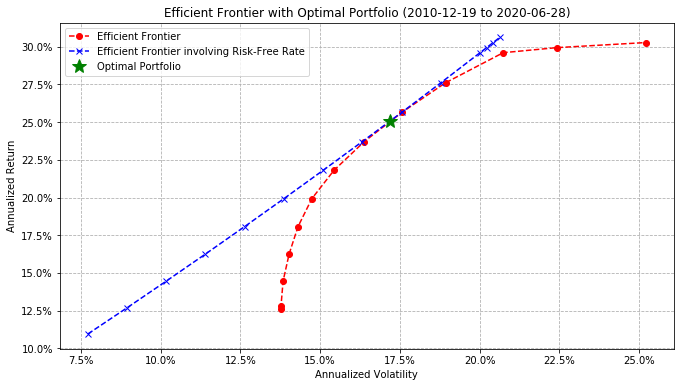

In [36]:
# Plotting efficient frontiers and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(port_vol_with_rf), ann_ret(port_return_with_rf), 'bx--', 
         label='Efficient Frontier involving Risk-Free Rate') #plot efficient frontier involving risk-free rate
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

#### Reduced Risks by Combining max Sharpe point and risk-free rate.

Suppose we construct a portfolio with:

- 90% of our wealth investing in the max Sharpe portfolio (i.e. portfolio with weight defined by the max Sharpe point) and 
- 10% of our wealth investing in risk-free rate (represented by the T-Bill returns). 

What is the risk (or volatility) of such portfolio?

Recall that portfolio risk (or volatility) is calculated by $$\text{Portfolio Risk} = \sqrt{w^T Q w}$$ where $w$ is a vector representing the portfolio weights for the assets and $Q$ is the variance-covariance matrix of the assets.

Note that the covariance matrix we calculated before didn't include the risk-free rate. Therefore, we need to re-calculate the convariance matrix before we can proceed to calculate the portfolio risk.

In [37]:
# Calculate the portfolio weight (90% max Sharpe + 10% risk-free rate)
w_port1 = np.append(0.9 * w_SR, 0.1)

# Calculate the portfolio risk
risk_port1 = np.sqrt( w_port1 @ data_train_with_rf_cov_mat @ w_port1)

print('The new portfolio risk (annualized) is:', ann_std(risk_port1))
print('The portfolio risk (annualized) for the max Sharpe point was:', ann_std(PVol(w_SR)))

The new portfolio risk (annualized) is: 0.15465196590933747
The portfolio risk (annualized) for the max Sharpe point was: 0.17183414900398963


#### Increased Risks by Borrowing at risk free rate and Levering max Sharpe point

Suppose we construct another portfolio with:

- borrowing at risk-free rate to lever the max Sharpe portfolio such that we can have a portfolio with weights adding up to 120%

What is the risk (or volatility) of such portfolio?

In [38]:
# Calculate the portfolio weight (borrowing at risk-free rate and levering max Sharpe point)
w_port2 = np.append(1.2*w_SR, -0.2)

# Calculate the portfolio risk
risk_port2 = np.sqrt( w_port2 @ data_train_with_rf_cov_mat @ w_port2)

print('The new portfolio risk (annualized) is:', ann_std(risk_port2))
print('The portfolio risk (annualized) for the max Sharpe point was:', ann_std(PVol(w_SR)))

The new portfolio risk (annualized) is: 0.20619870936119217
The portfolio risk (annualized) for the max Sharpe point was: 0.17183414900398963


## 8. Conducting Back-Tests <a id="8"></a>

Notice that, when we construct the Markowitz problem, we use the expected return and covariance matrix as a given input; this in fact shows that we have made some assumptions regarding the returns of the stocks and that the resulting asset allocation is an idealized solution based on the assumptions.  

Therefore, to better evaluate the performance of the portfolio, we will use real-world conditions and perform back-test(s) on the resulting asset allocation using actual historical returns. One might note that the asset allocation from the idealized efficient frontier may not be exactly on the efficient frontier due to skewness and kurtosis over the historical period.

In [39]:
###########################################   CAN BE CHANGED  #############################################

# Specify the start and end date for the back test  (can also use BT_startdate = 'YYYY-MM-DD') 
# CAUTION: Make sure that the date is within our specified time period from Section 1
BT_startdate = str(data.index[0].date())
BT_enddate = str(data.index[-1].date())

###########################################   CAN BE CHANGED  #############################################

In [40]:
# Trim dataset to have the specified start and end dates for the historical back test
data_BT = data[BT_startdate:BT_enddate].copy()
SP500_BT = SP500[BT_startdate:BT_enddate].copy()
TBill_BT = TBill[BT_startdate:BT_enddate].copy()

### Buy-and-Hold Strategy

In [41]:
# Functions to calculate the portfolio return for back-testing given portfolio weight
# Return the portfolio return over the full back-testing period
# Buy-and-hold strategy
def portRet_BH(w): 
    n = data_BT.shape[0]
    PR = np.zeros(n) 
    X = w * 1 #initial wealth assume to be 1
    for i in range(n):
        W = (1+data_BT.iloc[i]) @ X #wealth after each period
        PR[i] = (W - np.sum(X))/np.sum(X) #calculate and record portfolio return for that period
        X = (1+data_BT.iloc[i]) * X #how much of the wealth is invested in each asset
    return PR

# Function to display the summary statistics of the back test results
# It takes in the portfolio returns dataframe and returns the mean and standard deviation of the portfolio returns
def DisplaySummary_BT(PR, n_dec = 2):
    col_names = PR.columns
    
    # Compute and display summary statistics for each portfolio
    print('Summary statistic of various allocations for the back test (from '+
          str(BT_startdate)+' to '+str(BT_enddate)+'):')
    PR_mean = PR.mean()
    PR_std = PR.std()
    BT = pd.DataFrame(index = col_names)
    BT['Geo Mean(Annu,%)'] = np.round( PR.apply(ann_geo_mean) *100, n_dec)
    BT['Std(Annu,%)'] = np.round( ann_std(PR.std()) *100, n_dec)
    BT['Sharpe Ratio (Annu)'] = np.round( PR.apply(ann_sr, rf=TBill_BT['T-Bill']), n_dec)
    BT['Max Drawdown(%)'] = np.round(PR.apply(mdd)*100, n_dec)
    display(BT)
    
    return PR_mean,PR_std

In [42]:
# Add the equal weighted portfolio to our portfolio allocation dataframe
n_stocks = len(data.columns)
w_EQ = np.array(np.ones(n_stocks))/n_stocks
DF_Alloc_R['Equal'] = w_EQ

In [43]:
# Calculate the weekly portfolio return for each asset mix in df_alloc_r 
# (note: takes a bit time for this block to run)
col_names = DF_Alloc_R.columns
PR_BH = pd.DataFrame(index = data_BT.index, columns = col_names)
for i in range(len(col_names)):
    w = DF_Alloc_R.iloc[:,i].values
    PR_BH[col_names[i]] = portRet_BH(w)  

In [44]:
# Display Results for Buy-and_Hold strategy
print('Using Buy-and-Hold strategy: ')
PR_BH_mean,PR_BH_std = DisplaySummary_BT(PR_BH)

Using Buy-and-Hold strategy: 
Summary statistic of various allocations for the back test (from 2010-12-19 to 2020-06-28):


,"Geo Mean(Annu,%)","Std(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
10.9%,12.87,13.92,0.95,-22.53
12.7%,13.07,13.93,0.97,-22.55
14.5%,14.73,14.05,1.08,-23.15
16.3%,16.33,14.27,1.18,-23.61
18.1%,17.51,14.47,1.25,-23.99
19.9%,19.13,14.97,1.32,-24.46
21.8%,20.71,15.76,1.36,-25.19
23.7%,22.14,16.74,1.38,-25.71
25.6%,23.42,17.88,1.38,-26.31
27.6%,24.60,19.08,1.37,-26.85


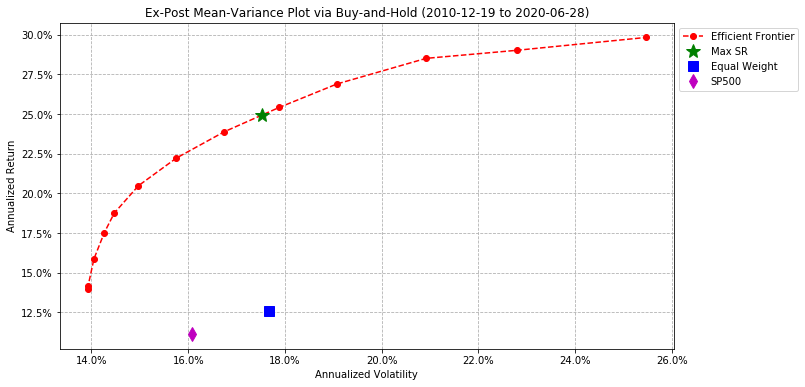

In [45]:
# Plotting Ex-Post efficient frontier and mark the various portfolios
plt.rcParams['figure.figsize'] = (11, 6)
# Plot efficient frontier
num_rbar = np.sum(PR_BH.columns.str.contains('%', case=False))
plt.plot(ann_std(PR_BH_std[:num_rbar]), ann_ret(PR_BH_mean[:num_rbar]), 'ro--' , label='Efficient Frontier')
# Plot optimal portfolio
plt.plot(ann_std(PR_BH_std['maxSR']), ann_ret(PR_BH_mean['maxSR']), 'g*', markersize=15, label='Max SR')
# Plot equal weighted portfolio
plt.plot(ann_std(PR_BH_std['Equal']), ann_ret(PR_BH_mean['Equal']), 'bs', markersize=10, label='Equal Weight')
# Plot SP500 
plt.plot(ann_std(SP500_BT.std()), ann_ret(SP500_BT.mean()), 'md', markersize=10, label='SP500')
# Customize the plot
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Ex-Post Mean-Variance Plot via Buy-and-Hold ('+str(BT_startdate)+' to '+str(BT_enddate)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## 9. Interpreting Output Recommendations  <a id="9"></a>

Looking at the efficient frontier and its corresponding dataframe with asset allocations, we can clearly observe that:

- Portfolio on the top right end of efficient frontier consists of only one or two stocks

- Portfolio on the bottom left end of efficient frontier tend to be more conservative and with greater diversification

There is great advantage of solving Markowitz Problem IF we have excellent estimates of future performance – motivation to search for improving forecasts.